(754, 1262, 3)


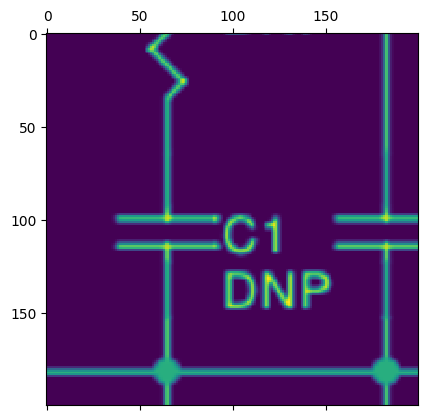

In [133]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
import random 

# Load image"
# image_path = "/Users/nshelton/Pictures/gundam_title.png"
image_path = "/Users/nshelton/Pictures/power86.png"


image = cv2.imread(image_path)
print(image.shape)

# image[:,:,1] = image[:,:,0]
# image[:,:,2] = image[:,:,0]

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.resize(image_gray, (-1,-1), fx = 2, fy = 2)
 
# _ , filtered =  cv2.threshold(image_gray, 150, 255, cv2.THRESH_BINARY_INV)

filtered = image_gray

# sigma = 2
# min_canny = 2
# max_canny = 100
# filtered = canny(image_gray, sigma, min_canny, max_canny).astype(np.uint8) * 255


filtered = 255 - filtered

filtered = filtered[400:600, 400:600]
cv2.imwrite("filtered.png", filtered)



plt.matshow(filtered)


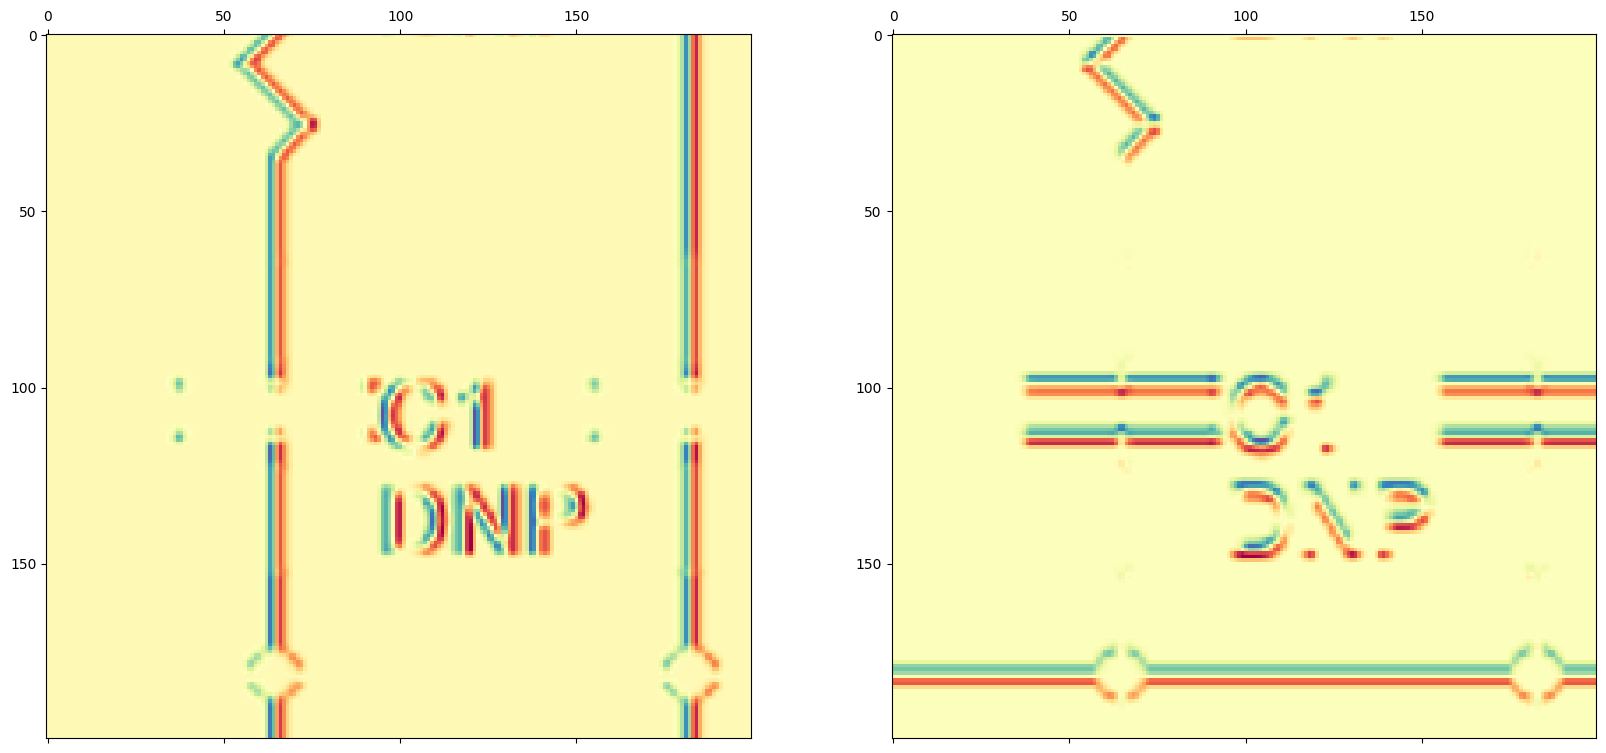

In [134]:

scale = 1
delta = 0
ddepth = cv2.CV_16S

grad_x = cv2.Sobel(filtered, ddepth, 1, 0, ksize=1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(filtered, ddepth, 0, 1, ksize=1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.matshow(grad_x, cmap="Spectral")
ax2.matshow(grad_y,  cmap="Spectral")

flow_field = np.dstack([-grad_y, grad_x])

In [ ]:
plt.plot(flow_field[100,:, :])



In [146]:

import cv2
import numpy as np

from pathUtils import *

remaining_ink = filtered.copy()
all_strokes_raster = np.ones(remaining_ink.shape) * 255

all_paths = []

while len(all_paths) < 50 and remaining_ink.sum() > 10:
    print(remaining_ink.sum(), "\t", len(all_paths),  end="\t\t\t\r")
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(remaining_ink)

    def placeStrokeGreedy(input_raster, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start)

        window = 2
        max_val = input_raster[start[0], start[1]]

        while(max_val > 0):
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img[pos[1] - window:pos[1] + window +1, pos[0] - window:pos[0] + window +1])
            pos += np.array(max_loc) - window 
            path.append(pos.copy())
            cv2.circle(img, pos, window-1, 0, -1)

        return path
    
    def lookupxy(raster, xy) : return raster[int(xy[1]), int(xy[0])]

    def placeStrokeOrthogonalGradient(input_raster, flow_field, start) :
        img = input_raster.copy()
        path = []
        pos = np.array(start, np.float32)
        threshold = 10
        print("start at", pos, lookupxy(img, pos))
        
        cv2.circle(img, (int(pos[1]), int(pos[0])), 1, 0, -1)

        speed = 2
        while int(pos[0]) < img.shape[1] and int(pos[1]) < img.shape[0] and lookupxy(img, pos) > threshold and len(path) < 1000:
            path.append(pos.copy())
            cv2.circle(img, (int(pos[1]), int(pos[0])), speed, 0, -1)

            flow = lookupxy(flow_field, pos)
            magnitude = np.linalg.norm(flow)
            delta = speed * flow / magnitude
            print("delta", delta)
            pos += delta

        return np.array(path)
    
    line_thickness = 2
    def rasterStroke(dims, path) :
        img = np.zeros(dims)
        for i in range(len(path)-1):
            a = (round(path[i][0]) , round(path[i][1]) )
            b = (round(path[i+1][0]) , round(path[i+1][1]) )
            cv2.line(img, a, b, 1, line_thickness, cv2.LINE_AA)
            
        return img

    
    new_stroke = placeStroke(remaining_ink, max_loc)
    # new_stroke = placeStrokeOrthogonalGradient(remaining_ink, flow_field, max_loc)

    print("new_stroke", new_stroke)
    all_paths.append(new_stroke)
    stroke_raster = rasterStroke(remaining_ink.shape, new_stroke)

    remaining_ink = remaining_ink - stroke_raster * 255
    remaining_ink = np.clip(remaining_ink, 0, 255)
    all_strokes_raster = np.clip(all_strokes_raster.astype(np.int32) - stroke_raster.astype(np.int32) * 255, 0, 255).astype(np.uint8)

    cv2.imwrite("current_stroke.png",  (all_strokes_raster).astype(np.uint8))
    cv2.imwrite("remaining_ink.png", remaining_ink)
    
# cv2.imwrite("current_stroke.png",  (all_strokes_raster).astype(np.uint8))
path_list = [[p.tolist() for p in path] for path in all_paths]

print(len(path_list))
# connect_close_paths(path_list)
path_list = [[p.tolist() for p in path] for path in all_paths]
render_img = plotPaths(path_list, 0.5)
cv2.imwrite("render.png", render_img)




start at [130. 144.] 236
delta [-0.1424941 -1.9949174]
delta [-1.72483157  1.01240114]
delta [-1.05270923  1.70053029]
delta [1.14517727 1.63968564]
delta [1.16365969 1.62662107]
delta [1.70079101 1.05228796]
new_stroke [[130.      144.     ]
 [129.85751 142.00508]
 [128.13268 143.01749]
 [127.07996 144.71802]
 [128.22514 146.3577 ]
 [129.38881 147.98431]]
start at [119. 131.] 233.0
delta [-1.28827149  1.5298224 ]
delta [0.03100403 1.99975967]
delta [0.04957154 1.99938557]
delta [0. 2.]
delta [0. 2.]
delta [0. 2.]
delta [0. 2.]
delta [0. 2.]
delta [0.52346594 1.93028066]
delta [1.995995   0.12650673]
delta [ 1.41421356 -1.41421356]
new_stroke [[119.       131.      ]
 [117.71173  132.52982 ]
 [117.74274  134.52957 ]
 [117.792305 136.52896 ]
 [117.792305 138.52896 ]
 [117.792305 140.52896 ]
 [117.792305 142.52896 ]
 [117.792305 144.52896 ]
 [117.792305 146.52896 ]
 [118.31577  148.45924 ]
 [120.31177  148.58575 ]]
start at [122. 103.] 227.0
delta [ 1.94683434 -0.45807867]
delta [-0.1610

True

In [ ]:
path_list